In [1]:
import sys
# sys.path
# sys.path[5] = "C:\\ProgramData\\Anaconda3\\envs\\geoplot\\Lib\\site-packages"

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from osgeo import gdal

# import rasterio
#PlateCarree EqualEarth()

In [2]:
def get_geotiff_data(path):
    """
    get gdal raster data
    """
    ds = gdal.Open(path)
    gt = ds.GetGeoTransform()
    array = ds.ReadAsArray()
    
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    
    xres, yres = gt[1], gt[5]
    xcor, ycor = gt[0], gt[3]
    
    lat = np.arange(ycor, ycor + yres*ysize, yres)
    lon = np.arange(xcor, xcor + xres*xsize, xres)
    return lon, lat, array

In [3]:
def draw(ax1, title, lon, lat, array, vmin, vmax, levels, cmap, number):
    ax1.outline_patch.set_linewidth(0.3)
    #Setting colour properties
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    array[array==-9999] = np.nan
    cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), cmap=cmap,levels=levels, norm=norm, shading='nearest', extend="max")
    cbar = fig.colorbar(cs, orientation='horizontal', pad=0.09, shrink=1, fraction=0.03, aspect=50)
    # ax1.set_title(title, fontsize='medium')
    #Modify the length of the scale
    cbar.ax.tick_params(size=1)
    cbar.outline.set_linewidth(0.2)
    ax1.add_feature(cfeature.BORDERS, linewidth=0.15)
    ax1.set_global()
    ax1.coastlines(linewidth=0.2)
    a = ax1.gridlines(draw_labels=True, linewidth=0.2)
    a.top_labels = False
    ax1.text(
        0.65, 0.1, title,
        fontsize=10,
        style="italic",
        transform = ax1.transAxes
    )
    ax1.text(
        -0.03, 0.95, number,
        fontsize=8,
        transform = ax1.transAxes
    )

In [4]:
def draw_2(ax1, title, lon, lat, array, vmin, vmax, levels, cmap, number):
    ax1.outline_patch.set_linewidth(0.3)
    #Setting colour properties
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    array[array==-9999] = np.nan
    cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), cmap=cmap,levels=levels, norm=norm, shading='nearest', extend="both")
    cbar = fig.colorbar(cs, orientation='horizontal', pad=0.09, shrink=1, fraction=0.03, aspect=50)
    # ax1.set_title(title, fontsize='medium')
    #Modify the length of the scale
    cbar.ax.tick_params(size=1)
    cbar.outline.set_linewidth(0.2)
    ax1.add_feature(cfeature.BORDERS, linewidth=0.15)
    ax1.set_global()
    ax1.coastlines(linewidth=0.2)
    a = ax1.gridlines(draw_labels=True, linewidth=0.2)
    a.top_labels = False
    ax1.text(
        0.65, 0.1, title,
        fontsize=10,
        style="italic",
        transform = ax1.transAxes
    )
    ax1.text(
        -0.03, 0.95, number,
        fontsize=8,
        transform = ax1.transAxes
    )

In [5]:
def draw_area_plot(ax, levels_input, data, cmap):
    
    
    x = np.arange(-59.875, 90.125, 0.25)
    levels= list(levels_input)
    a = data.copy()
    a[np.isnan(a)] = -9999
    levels.append(a.max())
    levels = np.array(levels)
    if levels_input.shape[0] == 6:
        columns=["c1", "c2", "c3", "c4", "c5", "c6"]
    elif levels_input.shape[0] == 7:
        columns=["c1", "c2", "c3", "c4", "c5", "c6", "c7"]
    elif levels_input.shape[0] == 10:
        columns=["c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10"]
    elif levels_input.shape[0] == 11:
        columns=["c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10", "c11"]
    else:
        print("class number not in the list!")
        raise ValueError
    df_out = pd.DataFrame(columns=columns)
    for i in range(len(x)):
        df = pd.DataFrame(data[i, :])
        df.drop(index=df[df[0]<-1].index, axis=0, inplace=True)
        df["cut"] = pd.cut(df[0], bins=levels)
        gb = df.groupby(["cut"])
        df = gb.count()
        df_out.loc[i, :] = np.array(df[0])

    for i in range(len(df_out)):
        if df_out.loc[i, :].sum() == 0:
            continue
        else:
            df_out.loc[i, :] = df_out.loc[i, :] / df_out.loc[i, :].sum()

    for i in range(len(df_out)):
        for j in range(len(columns)):
            if j == 0:
                continue
            else:
                df_out.iloc[i, j] = df_out.iloc[i, j] + df_out.iloc[i, j-1]

    
    colors = []
    levels2 = levels_input
    cmap = plt.get_cmap(cmap)
    norm = plt.Normalize(0, 400)
    n = len(levels_input)
    space = levels[1] - levels[0]
    for l in levels_input:
        c = ((l+(space/2))/(levels_input[-1]+space)) * 400
        colors.append(cmap(norm(c)))

    for i, col in enumerate(df_out.columns):

        ax.fill_betweenx(x, np.array(df_out.loc[:, col][::-1], dtype=np.float32), label=col, zorder=-i, color=colors[i])
    ax.margins(0, 0)
    ax.set_xlim(0)
    ax.set_ylim(-55, 85)
    ax.set_axisbelow(False)
    ax.set_xlabel("Proportion")
    ax.set_ylabel("latitude")
    
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    
    ax.tick_params("x",which="major",
               length=1.34,width = 0.8,
               colors = "0.25")
    ax.tick_params("y",which="major",
                   length=1.34,width = 0.8,
                   colors = "0.25")
    ax.tick_params(which = "minor",
                   length = 1.34, width = 0.8,
                   labelsize=10,labelcolor = "0.25")

In [6]:
def draw_proportion_chart(ax, data, levels_input, cmap):
    
    levels= list(levels_input)
    a = data.copy()
    a[np.isnan(a)] = -9999
    levels.append(a.max())
    levels = np.array(levels)

    data = data.ravel()
    df = pd.DataFrame(data)
    df.drop(index=df[df[0]<-1].index, axis=0, inplace=True)
    df["cut"] = pd.cut(df[0], bins=levels)
    gb = df.groupby(["cut"])
    df = gb.count()
    # df_out.loc[0] = np.array(df[0])
    colors = []
    levels2 = levels_input
    cmap = plt.get_cmap(cmap)
    norm = plt.Normalize(0, 400)
    n = len(levels_input)
    space = levels[1] - levels[0]
    for l in levels_input:
        c = ((l+(space/2))/(levels_input[-1]+space)) * 400
        colors.append(cmap(norm(c)))


    # Pie 1
    wedges, texts = ax.pie(df[0], radius=1, colors=colors)

    for w in wedges:
        w.set_width(.5)

    wedges[0].set_visible(False)

    # Pie 2
    wedges1, texts1 = ax.pie(df[0], radius=1.1, colors=colors)

    for w in wedges1:
        w.set_width(.6)

    wedges1[1].set_visible(False)
    wedges1[2].set_visible(False)
    wedges1[3].set_visible(False)

In [7]:
# input_folder = "E:\\weather extreme\\pr_record_breaking_proba_uncertain\\V2\\"
output_folder = "G:\\weather extreme\\mapping_result\\"

C:\Users\Bohao Li\AppData\Local\Temp\ipykernel_14696\2424047914.py:2: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linewidth(0.3)
D:\software\Anaconda\envs\geomapping\lib\site-packages\cartopy\mpl\geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'shading'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
C:\Users\Bohao Li\AppData\Local\Temp\ipykernel_14696\2424047914.py:2: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax1.outline_patch.set_linewidth(0.3)
D:\software\Anaconda\envs\geomapping\lib\site-packages\cartopy\mpl\geoaxes.py:1714: UserWarning: The following kwargs were not used by contour: 'shading'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
C:\Users\Bohao Li\AppData\Local\Temp\ipykernel_14696\2424047914.py:2: DeprecationWarning: 

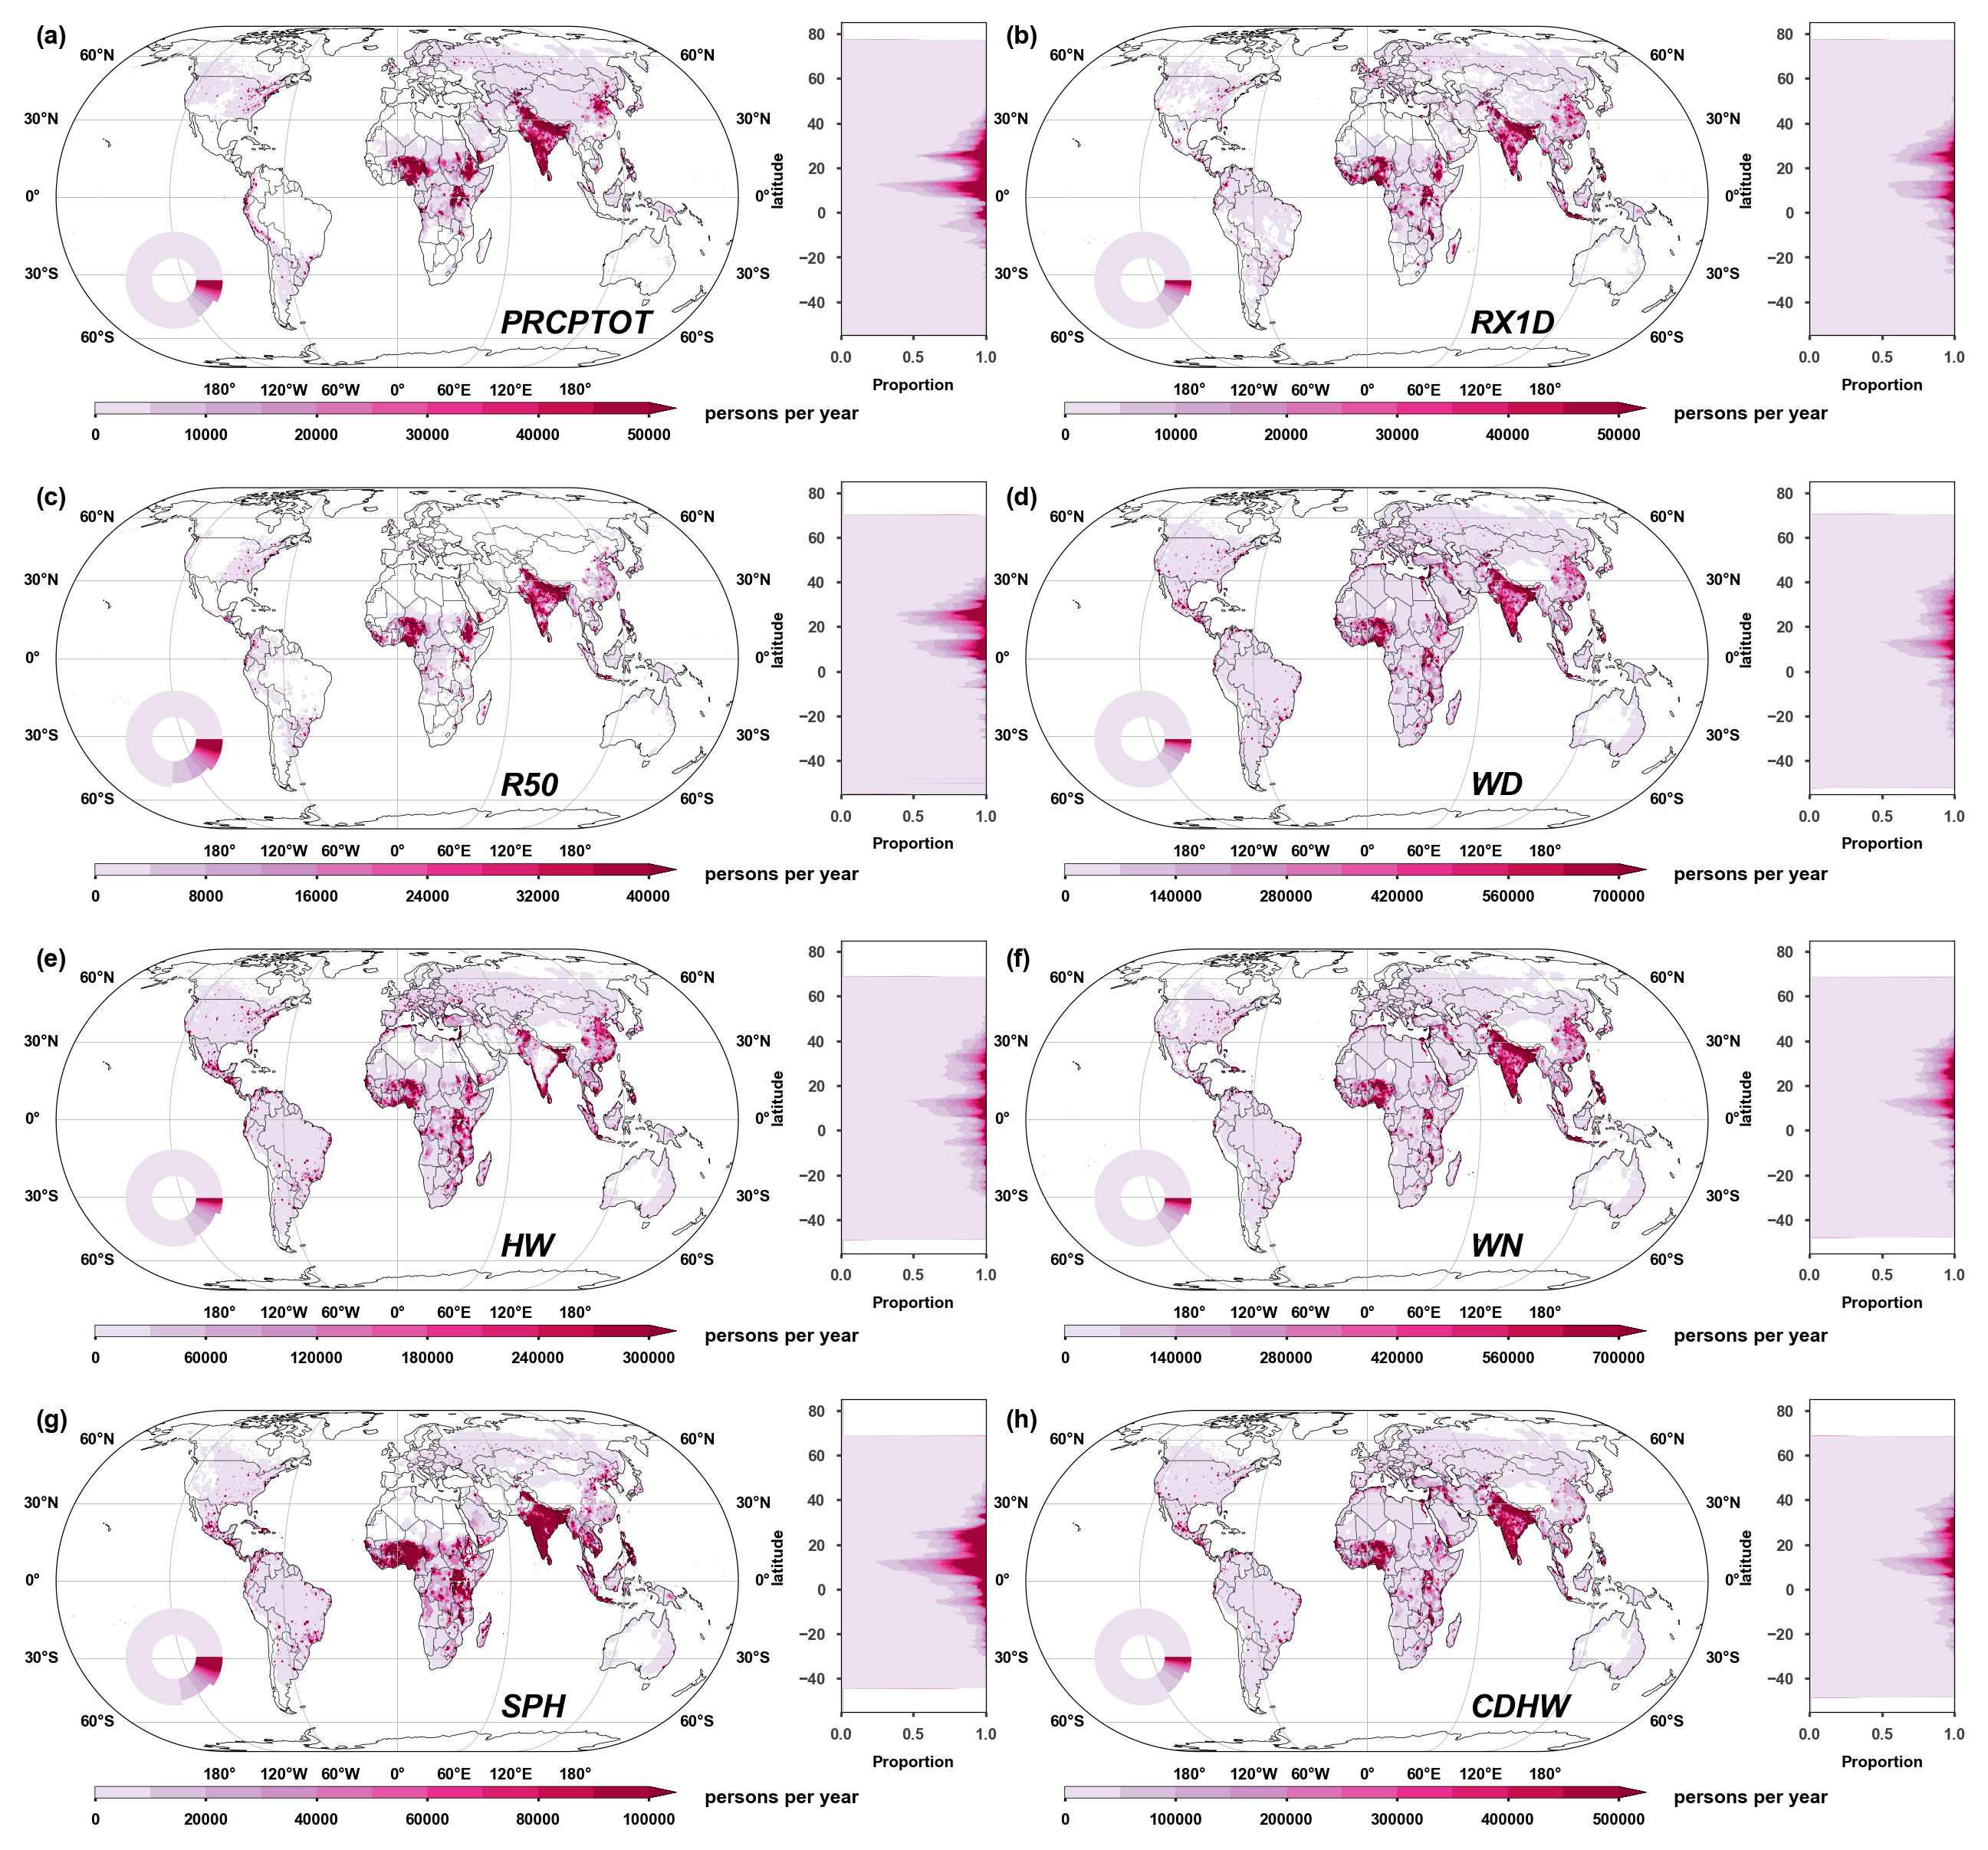

In [8]:
#precipitation CM YlGnBu
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
clist = ["#3D26A8", "#4332CA", "#4746EB", "#4757F7", "#3E6FFE", "#2E81F9", "#2796EB", "#1FA4E2", "#07B4D0",
         "#18BFB5", "#31C59F", "#56CC7A", "#80CB58", "#B8C430", "#DCBC28", "#FDBD3C", "#FCCF30", "#F4E824", "#F9FA14"]

clist = ["#F1EEF6", "#D5B9D8", "#CA95C8", "#E065AF", "#E92A8B", "#CE1255", "#930032"]
# clist = ["#009392","#72aaa1","#b1c7b3","#f1eac8","#e5b9ad","#d98994","#d0587e"]
newcmap = LinearSegmentedColormap.from_list('chaos',clist)

fig = plt.figure(figsize=(9,8), dpi=300)

plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":5})
projection = ccrs.EckertIV()

ax1 = fig.add_subplot(4, 2, 1,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\mapping_data\exposure\PRCPTOT\accumulate_pr_ssp370_lat_median_exposure.tif")
array[array<=0] = np.nan
draw(ax1, 'PRCPTOT', lon, lat, array, vmin=0, vmax=50000, levels=np.arange(0, 55000, 5000), cmap=newcmap, number="(a)")

ax11 = plt.axes([0.48, 0.82, 0.07, 0.170])
draw_area_plot(ax11, np.arange(0, 55000, 5000), array, newcmap)

ax111 = plt.axes([0.128, 0.82, 0.06, 0.06])
draw_proportion_chart(ax111, array, np.arange(0, 55000, 5000), newcmap)

ax2 = fig.add_subplot(4, 2, 2,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\mapping_data\exposure\RX1D\max_daily_pr_ssp370_lat_median_exposure.tif")
array[array<=0] = np.nan
draw(ax2, 'RX1D', lon, lat, array, vmin=0, vmax=50000, levels=np.arange(0, 55000, 5000), cmap=newcmap, number="(b)")

ax12 = plt.axes([0.948, 0.82, 0.07, 0.170])
draw_area_plot(ax12, np.arange(0, 55000, 5000), array, newcmap)

ax122 = plt.axes([0.596, 0.82, 0.06, 0.06])
draw_proportion_chart(ax122, array, np.arange(0, 55000, 5000), newcmap)

ax3 = fig.add_subplot(4, 2, 3,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\mapping_data\exposure\R50\preceed50mm_pr_ssp370_lat_median_exposure.tif")
array[array<=0] = np.nan
draw(ax3, 'R50', lon, lat, array, vmin=0, vmax=40000, levels=np.arange(0, 44000, 4000), cmap=newcmap, number="(c)")

ax33 = plt.axes([0.48, 0.5706, 0.07, 0.170])
draw_area_plot(ax33, np.arange(0, 44000, 4000), array, newcmap)

ax333 = plt.axes([0.128, 0.5706, 0.06, 0.06])
draw_proportion_chart(ax333, array, np.arange(0, 44000, 4000), newcmap)

ax4 = fig.add_subplot(4, 2, 4,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\heat(tasmax)\exposure\WD_ssp370_lat_median_exposure.tif")
array[array<=0] = np.nan
draw(ax4, 'WD', lon, lat, array, vmin=0, vmax=700000, levels=np.arange(0, 770000, 70000), cmap=newcmap, number="(d)")

ax44 = plt.axes([0.948, 0.5706, 0.07, 0.170])
draw_area_plot(ax44, np.arange(0, 770000, 70000), array, newcmap)

ax444 = plt.axes([0.596, 0.5706, 0.06, 0.06])
draw_proportion_chart(ax444, array, np.arange(0, 770000, 70000), newcmap)

ax5 = fig.add_subplot(4, 2, 5,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\heatwave\HW_exposure\HW_ssp370_lat_median_exposure.tif")
array[array<=0] = np.nan
draw(ax5, 'HW', lon, lat, array, vmin=0, vmax=300000, levels=np.arange(0, 330000, 30000), cmap=newcmap, number="(e)")

ax55 = plt.axes([0.48, 0.3212, 0.07, 0.170])
draw_area_plot(ax55, np.arange(0, 330000, 30000), array, newcmap)

ax555 = plt.axes([0.128, 0.3212, 0.06, 0.06])
draw_proportion_chart(ax555, array, np.arange(0, 330000, 30000), newcmap)

ax6 = fig.add_subplot(4, 2, 6,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\warmnight(tasmin)\WN_exposure\WN_ssp370_lat_median_exposure.tif")
array[array<=0] = np.nan
draw(ax6, 'WN', lon, lat, array, vmin=0, vmax=700000, levels=np.arange(0, 770000, 70000), cmap=newcmap, number="(f)")

ax66 = plt.axes([0.948, 0.3212, 0.07, 0.170])
draw_area_plot(ax66, np.arange(0, 770000, 70000), array, newcmap)

ax666 = plt.axes([0.596, 0.3212, 0.06, 0.06])
draw_proportion_chart(ax666, array, np.arange(0, 770000, 70000), newcmap)

ax7 = fig.add_subplot(4, 2, 7,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\SPH\SPH_exposure\SPH_ssp370_lat_median_exposure.tif")
array[array<=0] = np.nan
draw(ax7, 'SPH', lon, lat, array, vmin=0, vmax=100000, levels=np.arange(0, 110000, 10000), cmap=newcmap, number="(g)")

ax77 = plt.axes([0.48, 0.0718, 0.07, 0.170])
draw_area_plot(ax77, np.arange(0, 110000, 10000), array, newcmap)

ax777 = plt.axes([0.128, 0.0718, 0.06, 0.06])
draw_proportion_chart(ax777, array, np.arange(0, 110000, 10000), newcmap)

ax8 = fig.add_subplot(4, 2, 8,
                      projection=projection)
lon, lat, array = get_geotiff_data(r"G:\weather extreme\Revision\CDHW\CDHW_exposure\CDHW_ssp370_lat_median_exposure.tif")
array[array<=0] = np.nan
draw(ax8, 'CDHW', lon, lat, array, vmin=0, vmax=500000, levels=np.arange(0, 550000, 50000), cmap=newcmap, number="(h)")

ax88 = plt.axes([0.948, 0.0718, 0.07, 0.170])
draw_area_plot(ax88, np.arange(0, 550000, 50000), array, newcmap)

ax888 = plt.axes([0.596, 0.0718, 0.06, 0.06])

draw_proportion_chart(ax888, array, np.arange(0, 550000, 50000), newcmap)

plt.tight_layout(h_pad=2.5)
ax1.text(
    0.95, -0.15, "persons per year",
    fontsize=6,
    transform = ax1.transAxes
)
ax2.text(
    0.95, -0.15, "persons per year",
    fontsize=6,
    transform = ax2.transAxes
)
ax3.text(
    0.95, -0.15, "persons per year",
    fontsize=6,
    transform = ax3.transAxes
)
ax4.text(
    0.95, -0.15, "persons per year",
    fontsize=6,
    transform = ax4.transAxes
)
ax5.text(
    0.95, -0.15, "persons per year",
    fontsize=6,
    transform = ax5.transAxes
)
ax6.text(
    0.95, -0.15, "persons per year",
    fontsize=6,
    transform = ax6.transAxes
)
ax7.text(
    0.95, -0.15, "persons per year",
    fontsize=6,
    transform = ax7.transAxes
)
ax8.text(
    0.95, -0.15, "persons per year",
    fontsize=6,
    transform = ax8.transAxes
)

#下面注释不需添加
#  xticks = [-180, -120, -60, 0, 60, 120, 180]
# ax.set_xticks(xticks, crs=proj)
# ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=proj)
# lon_formatter = mticker.LongitudeFormatter(zero_direction_label=True)
# lat_formatter = mticker.LatitudeFormatter()
# ax.xaxis.set_major_formatter(lon_formatter)
# ax.yaxis.set_major_formatter(lat_formatter)


plt.savefig(output_folder + "extreme_ssp370_median_exposure_revised.jpg", dpi=1000, bbox_inches="tight")
plt.show()